## Table of Contents

1. [Imports](#imports)
2. [Module Definition](#module)
3. [Loading Data set](#dataset)
4. [Training Module](#Training)
5. [Testing Module](#Testing)


## Imports <a name="imports"></a>

In [1]:
# !pip install opencv-python==3.4.2.16
# !pip install opencv-contrib-python==3.4.2.16

In [13]:
import cv2
import numpy as np 
import glob
import os
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from random import randint
import pickle
import pandas as pd
from pretty_confusion_matrix import pp_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import time
import dataframe_image as dfi

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


### Modules Definition <a name="module"></a>

In [14]:
def get_features(train,surf):
    descriptor_list = []
    image_count = len(train)

    for img in train:
        kp, des = surf.detectAndCompute(img, None)
        descriptor_list.append(des)
        
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
        
    print("Descriptors vstacked.")
    
    return descriptors,descriptor_list

def get_vocabulary(descriptors, no_clusters):
    # clsuter feature descriptors to make dictonary 
    kmeans = MiniBatchKMeans(n_clusters = no_clusters).fit(descriptors)
    print("Vocabulary generated using Minibatch kmeans")
    return kmeans
    


def get_visual_words(descriptors,descriptor_list,dataset_count,no_of_clusters,kmeans):
    # predict each descriptor neighbours from dictonary
    visual_words = np.array([np.zeros(no_clusters) for i in range(dataset_count)])
    for i in range(dataset_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 64)
            idx = kmeans.predict(feature)
            visual_words[i][idx] += 1
    # standardize the visual words of each image 
    scale = StandardScaler().fit(visual_words)        
    visual_words = scale.transform(visual_words)

    print("Visual Words for image datatset created")

    return visual_words

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.savefig("histogram.png")
    plt.show()
    
def RF(img_features, train_labels,est):
    clf=RandomForestClassifier(n_estimators=est)
    clf.fit(img_features,train_labels)
    print(f'Final Training Accuracy: {clf.score(img_features,train_labels)*100}%')
    return clf

def plotConfusions(y_true, y_pred):
    rslts=[]
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=range(1, 11), columns=range(1, 11))
    # colormap: see this and choose your more dear
    cmap = 'tab20c'
    pp_matrix(df_cm, cmap=cmap)

    
    FP = cm.sum(axis=0) - np.diag(cm) 
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN) # is the probability that an actual positive will test positive
    rslts.append(TPR)
    # specificity
    TNR = TN/(TN+FP) #which is the probability that an actual negative will test negative
    rslts.append(TNR)
    FPR = FP/(FP+TN) # is the probability that a false alaram is raised 
    rslts.append(FPR)
    # # False negative rate is the probability that a true positive will be missed by the test
    FNR = FN/(TP+FN)
    rslts.append(FNR)
    
    df_rslts=pd.DataFrame(rslts)
    df_rslts.columns =['Class 0', 'Class 1','Class 2','Class 3','Class 4','Class 5','Class 6','Class 7','Class 8','Class 9']
    df_rslts.index = ['TPR', 'TNR', 'FPR', 'FNR']
    #df_styled=df_rslts.style.background_gradient(cmap)
    dfi.export(df_rslts,'Perf_rslts.png')
    display(df_rslts)

def ShowImage(train,tr_lbl,tr_pred,w):
    
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 5.2))
    fig.subplots_adjust(wspace=4,hspace=1)
    fig.tight_layout()

    # flatten the axis into a 1-d array to make it easier to access each axes
    axs = axs.flatten()
    r=[]
    # iterate through and enumerate the files, use i to index the axes
    for i in range(10):
        cnt=randint(0,len(train))
        r.append(cnt)
    for i in range(10):
        val=r[i]
        # add the image to the axes
        axs[i].imshow(train[val])
        # add an axes title; 
        if w==0:
            axs[i].set(title='Class:'+str(tr_lbl[val]))
        elif w==1:
            axs[i].set(title=f"Pred lbl: {tr_pred[val]}. True lbl: {tr_lbl[val]}")
        

    #add a figure title
    if w==0:
        fig.suptitle('Training Dataset', fontsize=16)
        plt.savefig('Train_data.png')
    elif w==1:
        fig.suptitle('Classified_Images', fontsize=16)
        plt.savefig('Classified_Images.png')
    
def misclassfied_images(test,tst_lbl,pred):
    mis_img=[]
    pred_lbl=[]
    act_lbl=[]
    for i in range(len(test)):
        if(pred[i] != tst_lbl[i]):
                # If these labels are not equal, the image has been misclassified
                mis_img.append((test[i]))
                pred_lbl.append(pred[i])
                act_lbl.append(tst_lbl[i])
    return mis_img,pred_lbl,act_lbl

def classfied_images(test,tst_lbl,pred):
    img=[]
    pred_lbl=[]
    act_lbl=[]
    for i in range(len(test)):
        if(pred[i] == tst_lbl[i]):
                # If these labels are not equal, the image has been misclassified
                img.append((test[i]))
                pred_lbl.append(pred[i])
                act_lbl.append(tst_lbl[i])
    return img,pred_lbl,act_lbl

def plot_misclassified_image(mis_images,pred_lbl,act_lbl):   
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 6))
    fig.subplots_adjust(wspace=1)
    #fig.tight_layout()

    # flatten the axis into a 1-d array to make it easier to access each axes
    axs = axs.flatten()
    # iterate through and enumerate the files, use i to index the axes
    for i in range(len(mis_images)):
        # add the image to the axes
        axs[i].imshow(mis_images[i])
        # add an axes title; 
        axs[i].set(title=f"Pred lbl: {pred_lbl[i]}. Actual lbl: {act_lbl[i]}")         

    #add a figure title
    fig.suptitle('Misclassified Images', fontsize=16)
    plt.savefig('misClassified.png')
    
    
def save_model(rf):
    with open('classifier_mdl', 'wb') as files:
        pickle.dump(rf, files)

def load_model(mdl):
    with open(mdl , 'rb') as f:
        random_forest = pickle.load(f)
        return random_forest

def perf_metrics(true, predictions):
    cmap = 'tab20c'
    print("Classification Report")
    accuracy=accuracy_score(true, predictions)
    print('Accuracy:', accuracy)
    report=classification_report(true, predictions,output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
   # df_styled1=df_classification_report.style.background_gradient(cmap)
    dfi.export(df_classification_report,'class_rslts.png')
    display(df_classification_report)
  

    


In [5]:
def load_dataset(dir_path):
    
    # append images 
    train=[]
    test=[]
    #log_indx=0
    tst_labels=[]
    train_labels=[]

    # iterate through all the foldrs in the path 
    print("Loading data set")
    for fld in os.listdir(path):
        #print("loading folder: " + fld)
        fld_path = os.path.join(path,fld)
       
        # load test and training record file
        rec_path=os.path.join(fld_path,'*.txt')
        files=glob.glob(rec_path)
      
        
        for txt_file in files:
         #   print('loading files')
            
            if os.path.basename(txt_file) =='test.txt':
                #print('loading test files')
                with open(txt_file) as f:
                    img_nm=[x.strip() for x in f.readlines()]
                    for i in img_nm:
                        data_path=os.path.join(fld_path,i)
                        img=cv2.imread(data_path,1)
                        img_resz=cv2.resize(img,(128,128))
                        test.append(img_resz)
                        tst_labels.append(int(fld)-1)
                    
                    
            if os.path.basename(txt_file)=='train.txt':
                #print('loading training files')
                with open(txt_file) as f:
                        img_nm1=[x.strip() for x in f.readlines()]
                        for i in img_nm1:
                            data_path=os.path.join(fld_path,i)
                            os.path.exists(data_path)
                            img=cv2.imread(data_path,1)
                            img_resz=cv2.resize(img,(128,128))
                            train.append(img_resz)
                            #rain.append(skimage.data.imread(data_path)
                            train_labels.append(int(fld)-1)
                            
    print('Successfully Loadded  {0} test images!'.format(len(test)))
    print('Successfully Loadded  {0} train images!'.format(len(train)))
    return np.array(train),np.array(test),np.array(train_labels),np.array(tst_labels)

        

In [6]:

def trainModel(train,train_labels, no_clusters,est):
    surf = cv2.xfeatures2d.SURF_create()
    dataset_count = len(train)
    
    descriptors,descriptors_list=get_features(train,surf)

    kmeans=get_vocabulary(descriptors, no_clusters)
    
    visual_words = get_visual_words(descriptors,descriptors_list,dataset_count, no_clusters,kmeans)
    print("Images features extracted.")

    plotHistogram(visual_words, no_clusters)
    print("Features histogram plotted.")
    
    visual_words, train_labels = shuffle(visual_words, train_labels)
    
    random_forest=RF(visual_words,train_labels,est)
   # img,pred_lbl,act_lbl=classfied_images(train,train_labels,tr_pred)
   # ShowImage(img,act_lbl,pred_lbl,1)
    save_model(RF)

    print("Randomforest fitted.")
    print("Training completed.")

    return random_forest,kmeans,descriptors

In [7]:
def testModel(test, test_lbl, rf, kmeans,no_clusters):
    count = len(test)
    surf = cv2.xfeatures2d.SURF_create()
    
    descriptors,descriptors_list=get_features(test,surf)
    
    visual_words = get_visual_words(descriptors,descriptors_list,count, no_clusters,kmeans)
    print("Images features extracted.")  
        
    predictions=rf.predict(visual_words)
    print("Test images classified.")

    plotConfusions(test_lbl, predictions)
    perf_metrics(test_lbl, predictions)
    
    print("Accuracy calculated.")
    print("Execution done.")
    
    return predictions

# Loading Data Set <a name="dataset"></a>

Loading data set
Successfully Loadded  200 test images!
Successfully Loadded  800 train images!


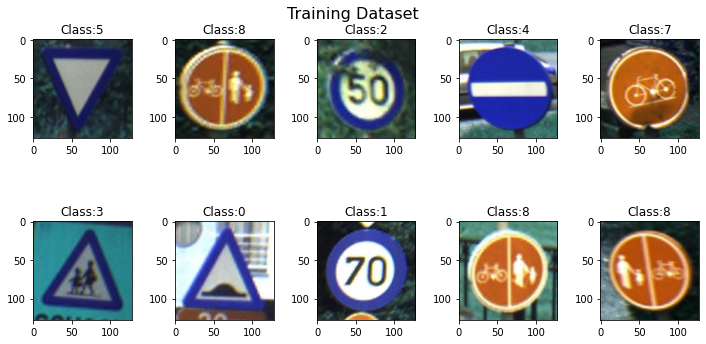

In [8]:
path='C:/Users/Ramesha/Documents/MS_Codes/semester2/CV/Assignment/Assignment1/CS893-Sp2022-A1-Dataset/'
train,test,tr_lbl,tst_lbl=load_dataset(path)
ShowImage(train,tr_lbl,tr_lbl,0)

# Training  <a name="training"></a>

Descriptors vstacked.


C:\Users\Ramesha\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Ramesha\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Ramesha\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1561: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Vocabulary generated using Minibatch kmeans
Visual Words for image datatset created
Images features extracted.


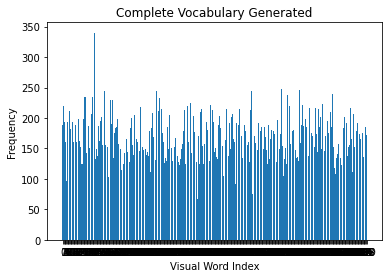

Features histogram plotted.
Final Training Accuracy: 100.0%
Randomforest fitted.
Training completed.
--- 111.82618975639343 seconds ---


In [9]:
no_clusters=400
est=200
start_time = time.time()
rf, kmeans,des = trainModel(train,tr_lbl, no_clusters,est)
print("--- %s seconds ---" % (time.time() - start_time))


# Testing <a name="Testing"></a>

Descriptors vstacked.
Visual Words for image datatset created
Images features extracted.
Test images classified.


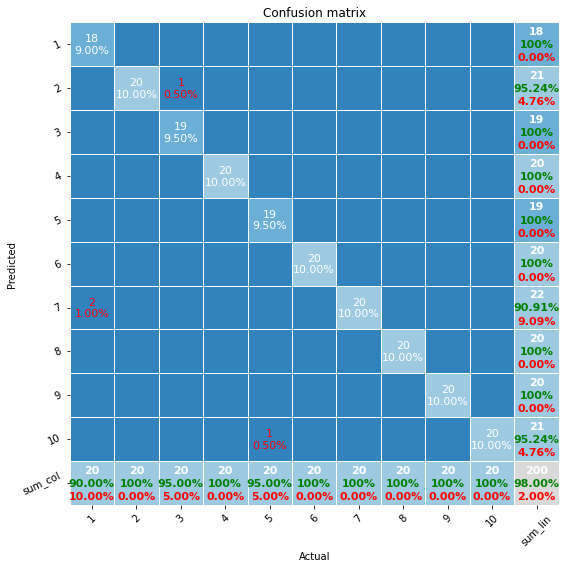

,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9
TPR,0.9,1.000000,0.95,1.0,0.95,1.0,1.000000,1.0,1.0,1.000000
TNR,1.0,0.994444,1.00,1.0,1.00,1.0,0.988889,1.0,1.0,0.994444
FPR,0.0,0.005556,0.00,0.0,0.00,0.0,0.011111,0.0,0.0,0.005556
FNR,0.1,0.000000,0.05,0.0,0.05,0.0,0.000000,0.0,0.0,0.000000


Classification Report
Accuracy: 0.98


,precision,recall,f1-score,support
0,1.000000,0.90,0.947368,20.00
1,0.952381,1.00,0.975610,20.00
2,1.000000,0.95,0.974359,20.00
3,1.000000,1.00,1.000000,20.00
4,1.000000,0.95,0.974359,20.00
5,1.000000,1.00,1.000000,20.00
6,0.909091,1.00,0.952381,20.00
7,1.000000,1.00,1.000000,20.00
8,1.000000,1.00,1.000000,20.00
9,0.952381,1.00,0.975610,20.00


Accuracy calculated.
Execution done.
--- 23.05422306060791 seconds ---


In [10]:
start_time = time.time()
pred=testModel(test,tst_lbl,  rf, kmeans, no_clusters)

print("--- %s seconds ---" % (time.time() - start_time))

#### Misclassified Images

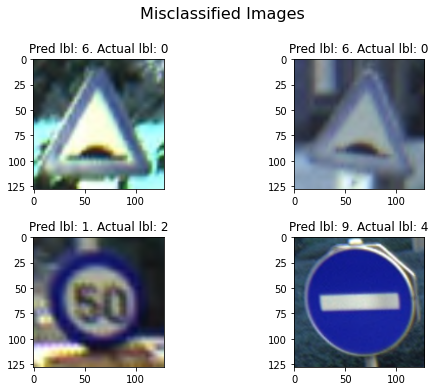

In [11]:
mis_img,pred_lbl,act_lbl=misclassfied_images(test,tst_lbl,pred)
plot_misclassified_image(mis_img,pred_lbl,act_lbl)


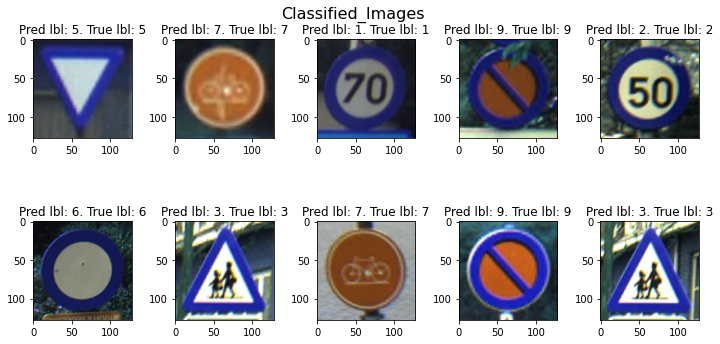

In [15]:
img,class_lbl,true_lbl=classfied_images(test,tst_lbl,pred)
ShowImage(img,true_lbl,class_lbl,1)